# Linear Regression - Top model according to the SCPM of -4.50 (dominance count 17)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

# Feature importance
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "206",
    "Plant": "B",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/206/b.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [9]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.320 (0.381)
MAE: -1.020 (0.275)
MAPE: -0.023 (0.007)
R2: 0.746 (0.123)


******
[TEST]
******
RMSE: -1.972 (0.692)
MAE: -1.569 (0.464)
MAPE: -0.036 (0.013)
R2: -0.144 (1.127)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,39.2875,41.826452,TRAIN
1,2020-01-02,48.0475,47.026808,TRAIN
2,2020-01-04,49.3350,47.229111,TRAIN
3,2020-01-07,41.8425,42.362436,TRAIN
4,2020-01-07,47.3150,46.777544,TRAIN
...,...,...,...,...
1160,2023-02-16,39.9700,43.523938,TEST
1161,2023-02-18,40.2000,43.541960,TEST
1162,2023-02-20,38.5075,43.584072,TEST
1163,2023-02-21,41.0575,43.169865,TEST


<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-02,39.2875,41.826452,TRAIN,CPIV32RS
1,2020-01-02,48.0475,47.026808,TRAIN,CPVARI
2,2020-01-04,49.3350,47.229111,TRAIN,CPVARI
3,2020-01-07,41.8425,42.362436,TRAIN,CPIV32RS
4,2020-01-07,47.3150,46.777544,TRAIN,CPVARI
...,...,...,...,...,...
1160,2023-02-16,39.9700,43.523938,TEST,CPIV32RS
1161,2023-02-18,40.2000,43.541960,TEST,CPIV32RS
1162,2023-02-20,38.5075,43.584072,TEST,CPIV32RS
1163,2023-02-21,41.0575,43.169865,TEST,CPIV32RS


<IPython.core.display.Javascript object>

In [14]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

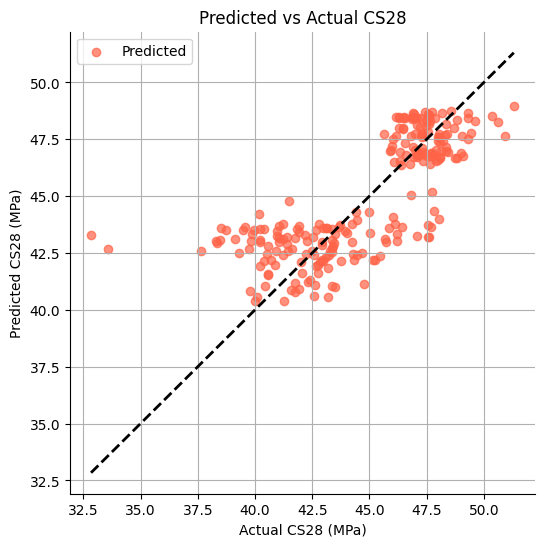

<IPython.core.display.Javascript object>

In [16]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_206_b_local_cm_p_btiss_top_scpm_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
df["Cement_Type"].value_counts()

Cement_Type
CPVARI      598
CPIV32RS    571
Name: count, dtype: int64

<IPython.core.display.Javascript object>

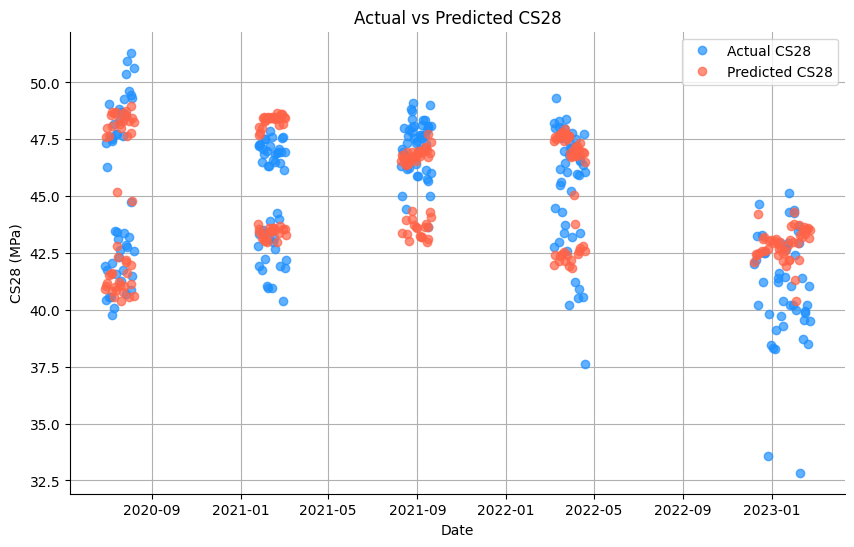

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_206_b_local_cm_p_btiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [19]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [20]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time
Coefficients - 0,0.310392,-0.313797,-0.931809,-2.169346,1.048414,0.407709,-1.375560,0.199340,-0.232703
Coefficients - 1,-0.612306,-0.095128,-0.366975,-1.222273,-0.253102,0.086993,-1.210802,0.096162,-0.142696
Coefficients - 2,-0.148434,-0.049672,-0.705405,-0.418723,-0.363767,0.190407,-0.903717,-0.117328,-0.154268
Coefficients - 3,0.086029,-0.016711,0.741865,-2.188798,1.203531,1.097054,-2.259893,0.182054,-0.262012
Coefficients - 4,-0.297808,-0.056067,0.271984,-0.770114,1.309964,-0.153755,-3.195645,0.413418,-0.050137


<IPython.core.display.Javascript object>

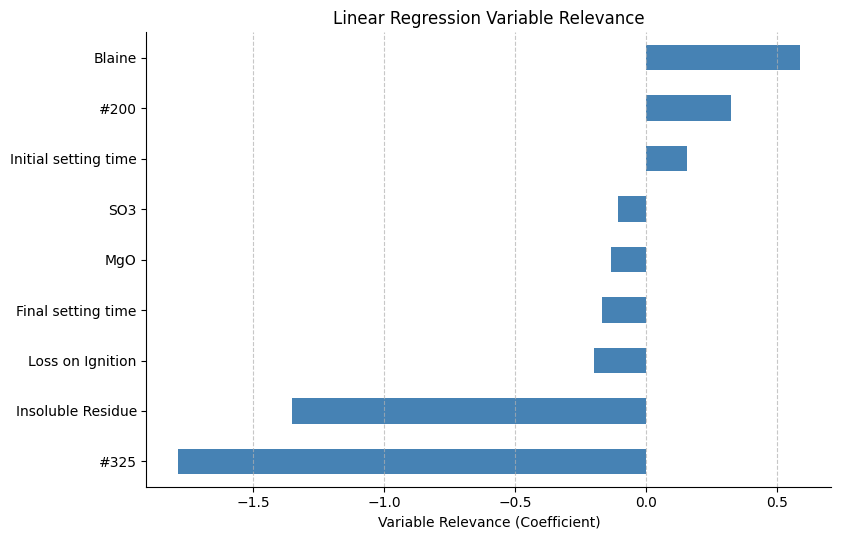

<IPython.core.display.Javascript object>

In [21]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

In [22]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

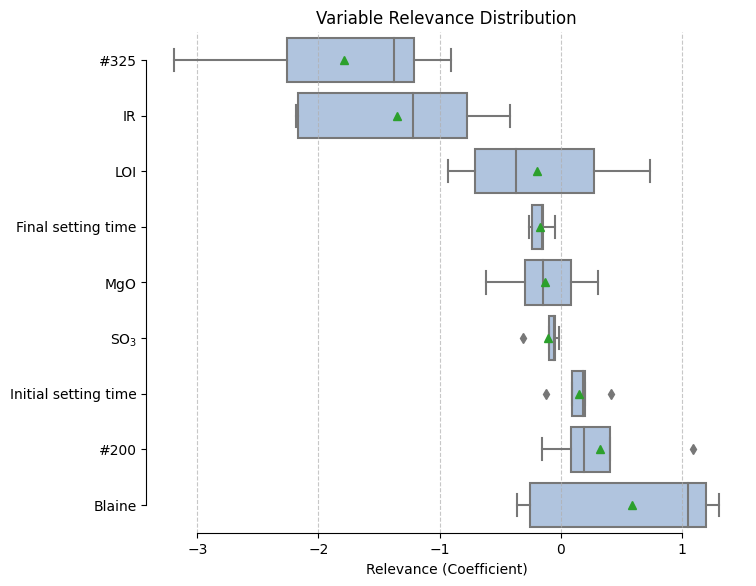

<IPython.core.display.Javascript object>

In [23]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_206_b_local_cm_p_btiss_top_scpm_dist_var_coef_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [24]:
df_importances

,MgO,SO3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time
Coefficients - 0,0.310392,-0.313797,-0.931809,-2.169346,1.048414,0.407709,-1.375560,0.199340,-0.232703
Coefficients - 1,-0.612306,-0.095128,-0.366975,-1.222273,-0.253102,0.086993,-1.210802,0.096162,-0.142696
Coefficients - 2,-0.148434,-0.049672,-0.705405,-0.418723,-0.363767,0.190407,-0.903717,-0.117328,-0.154268
Coefficients - 3,0.086029,-0.016711,0.741865,-2.188798,1.203531,1.097054,-2.259893,0.182054,-0.262012
Coefficients - 4,-0.297808,-0.056067,0.271984,-0.770114,1.309964,-0.153755,-3.195645,0.413418,-0.050137


<IPython.core.display.Javascript object>

In [25]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
#325,5.0,-1.789124,0.933992,-3.195645,-2.259893,-1.375560,-1.210802,-0.903717
Insoluble Residue,5.0,-1.353851,0.805403,-2.188798,-2.169346,-1.222273,-0.770114,-0.418723
Loss on Ignition,5.0,-0.198068,0.694391,-0.931809,-0.705405,-0.366975,0.271984,0.741865
Final setting time,5.0,-0.168363,0.083283,-0.262012,-0.232703,-0.154268,-0.142696,-0.050137
MgO,5.0,-0.132425,0.354155,-0.612306,-0.297808,-0.148434,0.086029,0.310392
SO3,5.0,-0.106275,0.119306,-0.313797,-0.095128,-0.056067,-0.049672,-0.016711
Initial setting time,5.0,0.154729,0.191770,-0.117328,0.096162,0.182054,0.199340,0.413418
#200,5.0,0.325682,0.476150,-0.153755,0.086993,0.190407,0.407709,1.097054
Blaine,5.0,0.589008,0.825439,-0.363767,-0.253102,1.048414,1.203531,1.309964


<IPython.core.display.Javascript object>

In [26]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [27]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

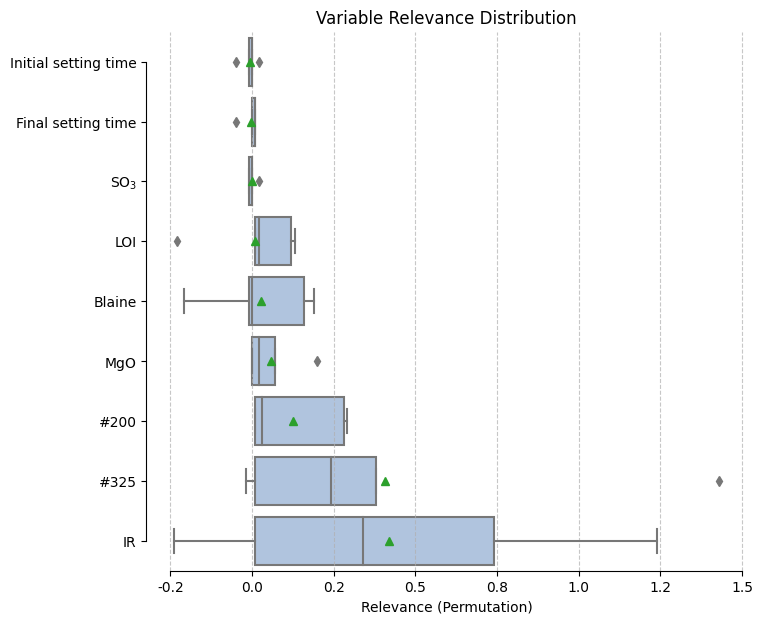

<IPython.core.display.Javascript object>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_206_b_local_cm_p_btiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [29]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Initial setting time,5.0,-0.0092,0.0261,-0.0520,-0.0097,-0.0019,-0.0013,0.0187
Final setting time,5.0,-0.0060,0.0254,-0.0507,-0.0028,0.0063,0.0070,0.0100
SO3,5.0,-0.0007,0.0157,-0.0149,-0.0134,-0.0000,0.0006,0.0243
LOI,5.0,0.0124,0.1452,-0.2292,0.0148,0.0250,0.1167,0.1344
Blaine,5.0,0.0267,0.1618,-0.2113,-0.0092,-0.0012,0.1635,0.1918
MgO,5.0,0.0575,0.0842,0.0013,0.0039,0.0160,0.0656,0.2007
#200,5.0,0.1237,0.1478,0.0079,0.0093,0.0308,0.2820,0.2887
#325,5.0,0.4084,0.5936,-0.0217,0.0111,0.2446,0.3802,1.4278
Insoluble Residue,5.0,0.4193,0.5886,-0.2359,0.0097,0.3379,0.7419,1.2427


<IPython.core.display.Javascript object>

In [30]:
perm_importances_df

,Initial setting time,Final setting time,SO3,LOI,Blaine,MgO,#200,#325,Insoluble Residue
0,-0.001868,0.006285,0.024303,0.134414,0.191791,0.015958,0.030787,0.244577,0.741945
1,-0.001349,-0.002833,-0.000018,0.014847,-0.009151,0.065594,0.009328,0.380234,0.337945
2,-0.051963,-0.050653,-0.014876,-0.229175,-0.211265,0.200688,0.288663,0.011120,-0.235941
3,0.018672,0.010005,0.000641,0.116721,0.163516,0.001265,0.281998,1.427783,1.242700
4,-0.009698,0.006976,-0.013416,0.024952,-0.001246,0.003865,0.007865,-0.021666,0.009724


<IPython.core.display.Javascript object>